# Running DESCQA

Owners: **PatriciaLarsen [@plarsen](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@patricialarsen)**  
Last Verifed to Run: **2024-06-04** (by @plarsen)

This notebook will show you how to run the SRV-DESCQA validation tools. We'll show you how to submit jobs to run them through the terminal, how to develop tests interactively on a notebook and how to look at the results. 
  
  
## List of tests  

Below you can see a chart of the currently implemented tests - purple (left-most) are photometry tests, green (second set) are shape tests, blue (middle column) are tests of flags, pink (fourth column) are external tests and teal (right) are interactive tests.

These are not guaranteed to be a complete set, if there's anything you'd like in the test suite which isn't implemented please ping the SRV group (current convenors Patricia and Yao) to add it to our list. 

![](../plots/SRV_tests.png)

## DP0.2 

This notebook will be updated to show how to do all this with the DP0.2 data and the SRV tests. The main changes are to use the SRV branch of DESCQA and the GCRCatalogs version mentioned in previous tutorials. A lot of the information is available here: https://docs.google.com/presentation/d/1ar-4lpOetJBX71M6LQeSqHLWoKzpJ1i0QpuVi8iJsO0/edit?usp=sharing

For the rest of the notebook this currently shows how to run the standard DESCQA in a notebook. This will be shortly updated to validation tests on DP0.2 data. 


## Running in terminal (preferred production method) 

For the most part when we run these tests you can use more resources, read data in parallel, and have the results automatically upload to the website by using the provided scripts in the terminal. I'll go through these first - then show you how to run and develop smaller tests in a notebook if you prefer to work more interactively. 


To get started download DESCQA from the github here:

```url
https://github.com/LSSTDESC/descqa
```

and then checkout the "SRV" branch. We don't currently have the SRV branch installed into the DESC kernels, this will likely change in future. 


Now for anything non-trivial you'll want to request an interactive node

```bash
salloc --nodes 1 --qos interactive --time 01:00:00 --constraint cpu --account=mxxxx
```

And then once there you can run with the catalog option and test option as follows. Note that the path addition is specifically to use a version of gcr-catalogs with the parallel reader (alter the options in the run_master script to enable parallelism)

```bash
./run_master.sh -p /global/cfs/projectdirs/lsst/groups/SRV/gcr-catalogs -c dp02_object_test -t srv_example

```

After a run you should then be able to go to the web output listed, which should point to your run on https://portal.nersc.gov/cfs/lsst/descqa/v2/?run=all

## Running in a notebook (can be good for development)

Note that the web interface and parallel read are currently not supported in the notebook, however you should be able to run tests and get results into a local output directory of your choice. Please be mindful of resource usage on shared nodes, we'll be running tests on small subsets of the catalogs for test purposes. 

## DC2

First let's start by doing some imports and defining some functions

In [2]:
import sys
sys.path.insert(0,'../utils')
from utils import * # this is fairly minimal, imports and select_subset, interpret_results functions hidden for tidiness

In [3]:
sys.path.insert(0,'/global/cfs/projectdirs/lsst/groups/SRV/gcr-catalogs-test')
sys.path.insert(0,'/global/cfs/projectdirs/lsst/groups/SRV/descqa')

GCRCatalogs = importlib.import_module('GCRCatalogs')
descqa = importlib.import_module('descqa')

Now let's decide on which tests to run. We're going to run a quick tutorial test I've set up which plots the number density of galaxies as a function of RA and declination, and we'll run it on a single-tract object catalog. 


In [5]:
validations_to_run = ['srv_tutorial']
catalogs_to_run = ['lsst_object']


In actually loading these we first confirm that they're available within the GCRCatalogs and DESCQA versions you've imported

In [6]:
# let's just confirm these exist first of all - will raise a big red error if you've got the wrong name!

validations_to_run = select_subset(descqa.available_validations, validations_to_run)
catalogs_to_run = select_subset(GCRCatalogs.get_available_catalogs(False), catalogs_to_run)
if not validations_to_run or not catalogs_to_run:
    raise RuntimeError('Nothing to run... Aborted!')
    


And now we load the catalog and the validation class. 

In [7]:
# now let's load the catalogs, since we're running this interactively we're skipping the exception catching 
catalog_instances={}
for catalog in catalogs_to_run:
    catalog_instances[catalog] = GCRCatalogs.load_catalog(catalog)
validation_instances={}
for validation in validations_to_run:
    validation_instances[validation] = descqa.load_validation(validation)


Finally let's tell it where to output the data, and then ask the validation class to run on the catalog!

In [8]:
output_dir_this = '../test_direc'  # point to a directory where you want to store any plots or results
test_result = validation_instances[validation].run_on_single_catalog(catalog_instances[catalog], catalog, output_dir_this)

All the results will output in the folder you've specified, however there is some information from the test_result itself, I've made a little convenience function to output the information from there:

In [9]:
interpret_result(test_result)

Status code:
VALIDATION_TEST_INSPECT

No pass/fail criterion specified, inspection only

Summary message:
made a histogram to inspect!


And let's grab the output sky area image and plot it in the notebook! 

../test_direc/test_histogram.png


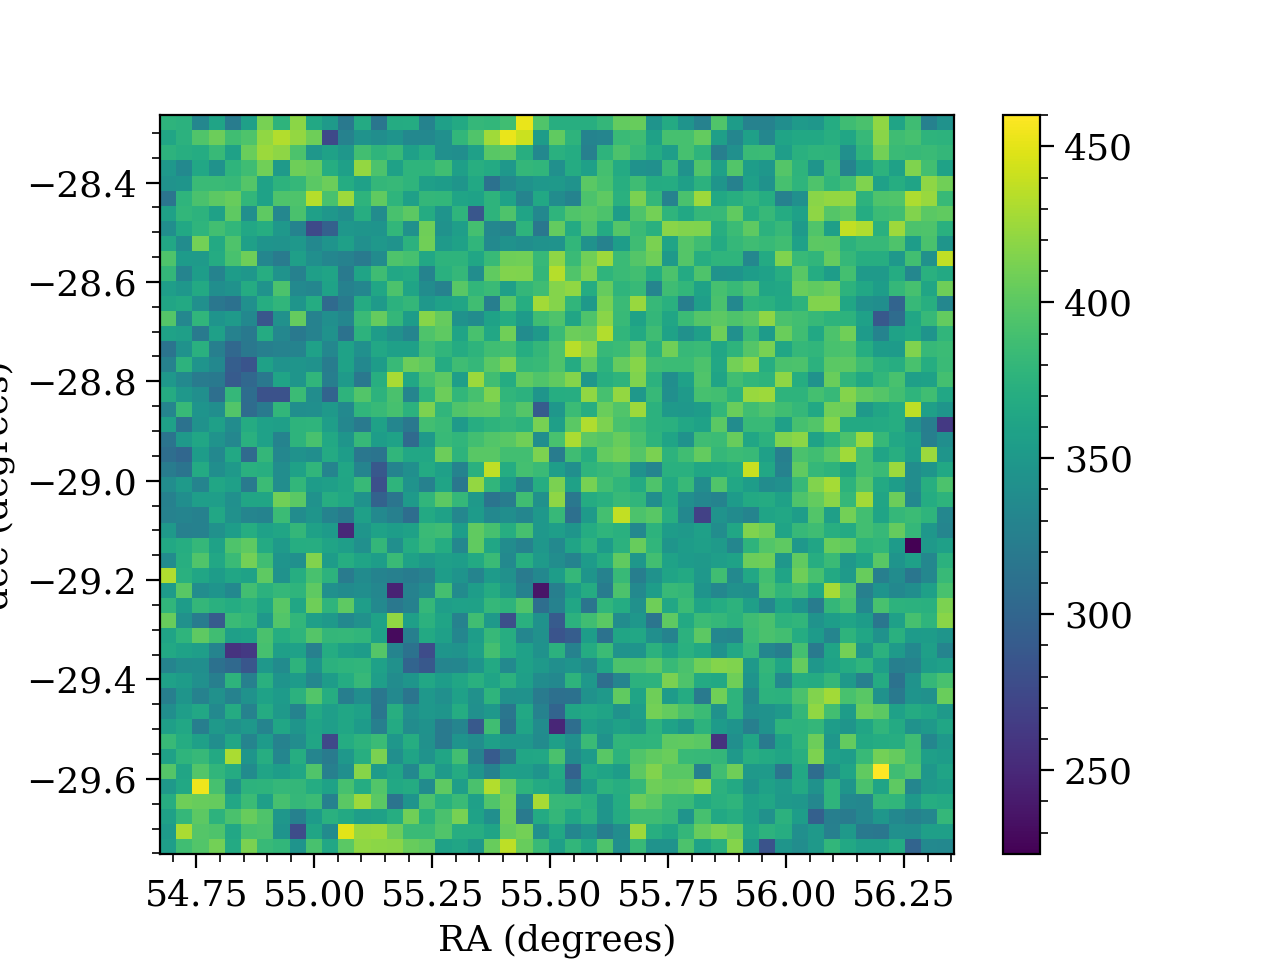

In [11]:
for image in glob.glob( output_dir_this + '/*.png'):
    print(image)
    display(Image.open(image))

### Development

Okay so we can run the tests, but can we actually develop them in the notebook? Sure! Let's copy that test class here and edit it to change the color of the map.  

In [12]:
#let's have a look at the test 
from descqa.base import BaseValidationTest, TestResult
import numpy as np
import healpy as hp
import os
import matplotlib.pyplot as plt
import matplotlib as mpl


class Tutorial2(BaseValidationTest):
    """
    validation test to plot RA/DEC
    """
    def __init__(self, **kwargs): # initialize and get the inputs 
        self.ra = kwargs.get('ra')
        self.dec = kwargs.get('dec')
        self.catalog_filters = kwargs.get('catalog_filters', [])


    def run_on_single_catalog(self, catalog_instance, catalog_name, output_dir): # run the operation

        if not catalog_instance.has_quantities([self.ra, self.dec]):
            return TestResult(skipped=True)

        # read in the data 
        data = catalog_instance.get_quantities([self.ra,self.dec],filters=self.catalog_filters, return_iterator=False)

        xbins = np.linspace(np.min(data[self.ra]),np.max(data[self.ra]),50)
        ybins = np.linspace(np.min(data[self.dec]),np.max(data[self.dec]),50)
        plt.figure()
        plt.hist2d(data[self.ra],data[self.dec], bins=(xbins,ybins),cmap='Blues')
        plt.colorbar()
        plt.xlabel('RA (degrees)')
        plt.ylabel('dec (degrees)')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'test_histogram.png')) # create output #1 
        plt.close()

        return TestResult(inspect_only=True, summary='made a histogram to inspect!') # add output information

We now just need to create a dictionary of input arguments to pass in, and then we can initialize the class with those arguments as our 
validation

In [13]:
# we need to create an input dictionary to give any arguments required in the __init__ code, then we just initialize and run!
dict_config = {}
dict_config['ra'] = 'coord_ra'
dict_config['dec'] = 'coord_dec'
dict_config['catalog_filters'] =  ['refExtendedness==1','detect_isPrimary']

validation2 = Tutorial2(**dict_config)


And we run it as before, swapping out the validation class

In [14]:
output_dir_this = '../test_direc'  # point to a directory where you want to store any plots or results
test_result = validation2.run_on_single_catalog(catalog_instances[catalog], catalog, output_dir_this)

In [15]:
interpret_result(test_result)

Status code:
VALIDATION_TEST_INSPECT

No pass/fail criterion specified, inspection only

Summary message:
made a histogram to inspect!


../test_direc/test_histogram.png


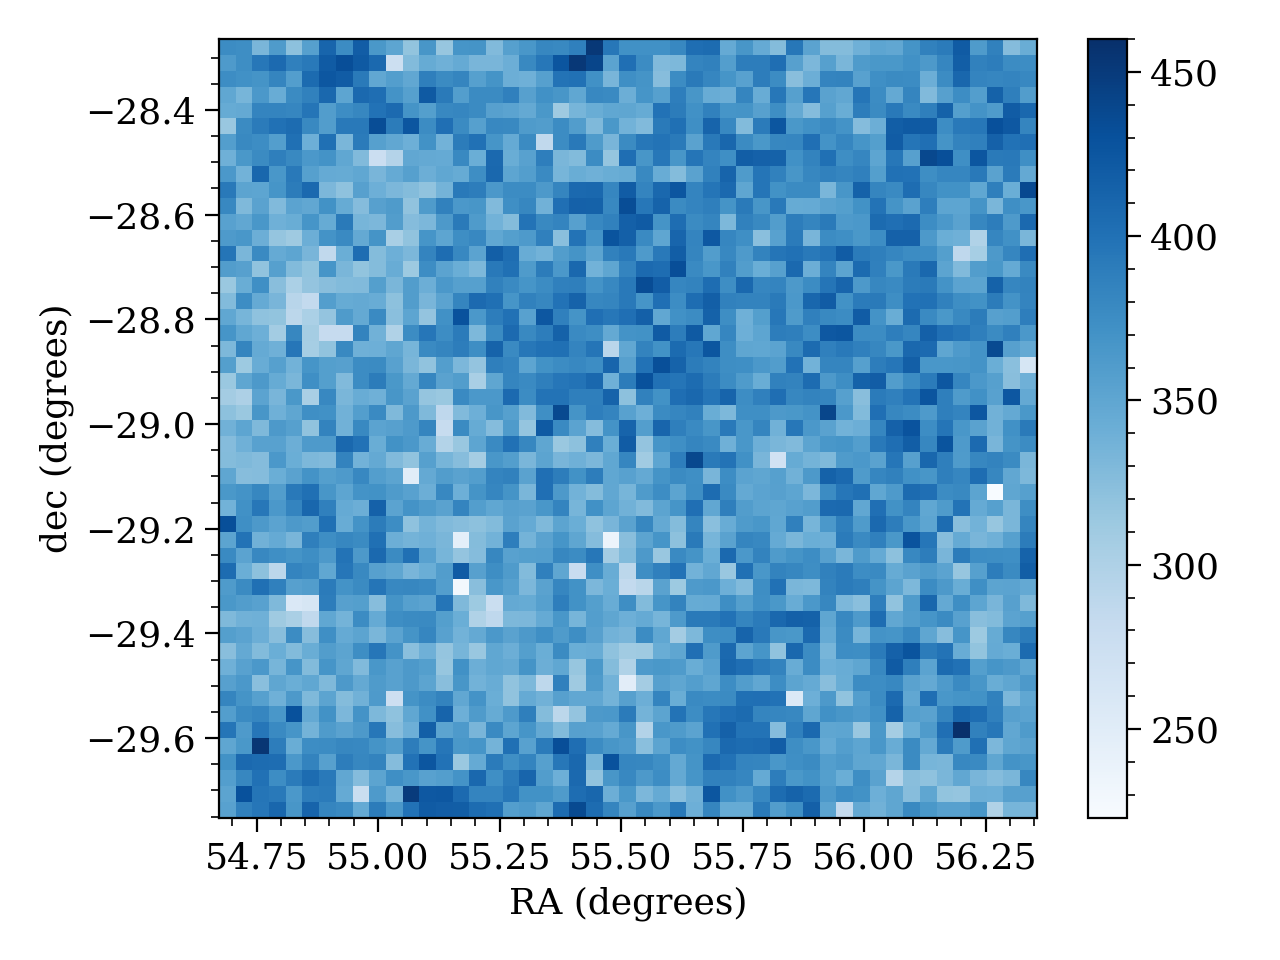

In [16]:
for image in glob.glob( output_dir_this + '/*.png'):
    print(image)
    display(Image.open(image))

## Passing in data

But what about when we're developing quickly and we don't want to load the data every time? Well when committing these tests we'll need to know how to get the data, but for quick re-runs you can always load the data externally and pass it in through the dictionary. This also works when there's a more expensive step but you just want to alter the output formatting. Let's say I really don't like either color and I want to mess around with more colormaps.  

In [20]:
## Now if we want to truly run and alter this interactively we might not want to waste time on IO, so why don't we pass in 
#the data as a dictionary in the meantime?
from descqa.base import BaseValidationTest, TestResult
import numpy as np
import healpy as hp
import os
import matplotlib.pyplot as plt
import matplotlib as mpl


class Tutorial3(BaseValidationTest):
    """
    validation test to plot RA/DEC
    """
    def __init__(self, **kwargs): # initialize and get the inputs 
        self.ra = kwargs.get('ra')
        self.dec = kwargs.get('dec')
        self.data = kwargs.get('data')

    def run_on_single_catalog(self, catalog_instance, catalog_name, output_dir): # run the operation

        if not catalog_instance.has_quantities([self.ra, self.dec]):
            return TestResult(skipped=True)

        # read in the data 
        data = self.data
        xbins = np.linspace(np.min(data[self.ra]),np.max(data[self.ra]),50)
        ybins = np.linspace(np.min(data[self.dec]),np.max(data[self.dec]),50)
        plt.figure()
        plt.hist2d(data[self.ra],data[self.dec], bins=(xbins,ybins),cmap='Reds')
        plt.colorbar()
        plt.xlabel('RA (degrees)')
        plt.ylabel('dec (degrees)')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'test_histogram.png')) # create output #1 
        plt.close()

        return TestResult(inspect_only=True, summary='made a histogram to inspect!') # add output information



The only added step I need is to take out that data read, and put it externally (note that we load the whole dataset here not an iterative chunk). 

In [21]:
filters =  ['refExtendedness==1','detect_isPrimary']

d = catalog_instances[catalog].get_quantities(['coord_ra', 'coord_dec'], filters=filters, return_iterator=False)


# we need to create an input dictionary to give any arguments required in the __init__ code, then we just initialize and run!
dict_config = {}
dict_config['ra'] = 'coord_ra'
dict_config['dec'] = 'coord_dec'
dict_config['data'] = d

validation3 = Tutorial3(**dict_config)


And now we just run the test without the read-in and can see what the new color looks like

In [22]:
output_dir_this = '../test_direc'  # point to a directory where you want to store any plots or results
test_result = validation3.run_on_single_catalog(catalog_instances[catalog], catalog, output_dir_this)

In [23]:
interpret_result(test_result)

Status code:
VALIDATION_TEST_INSPECT

No pass/fail criterion specified, inspection only

Summary message:
made a histogram to inspect!


../test_direc/test_histogram.png


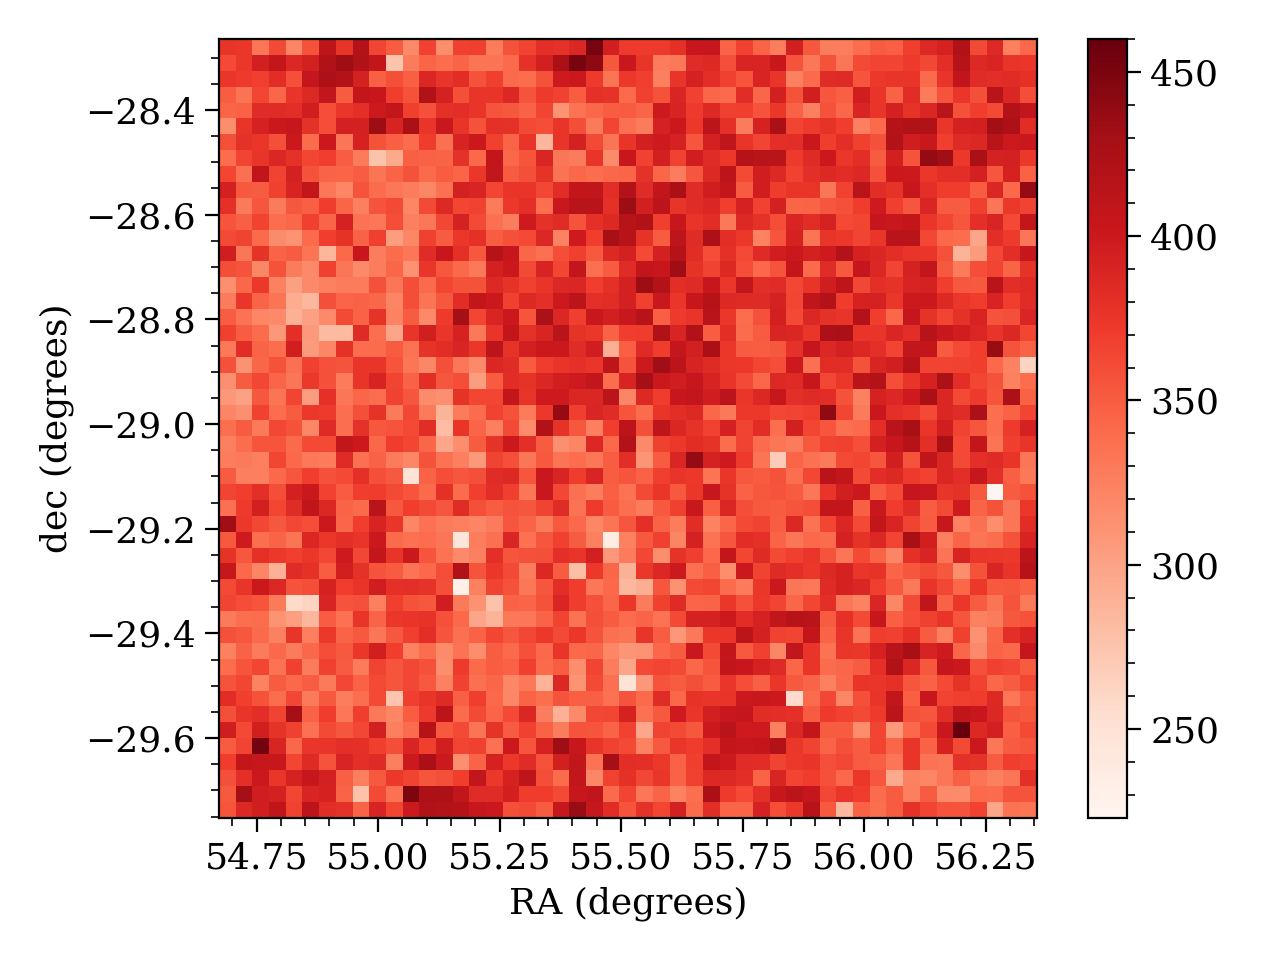

In [24]:
for image in glob.glob( output_dir_this + '/*.png'):
    print(image)
    display(Image.open(image))